# Array Print
`Array Print` takes a `.csv` representing a MITOMI-assayable library as input and returns a Scienion-compatible `.fld ` file and a csv record of the array layout. 

In [1]:
# Author: Micah Olivas
# Date: 09/27/2021

In [2]:
import os
import sys
import math
from ipyfilechooser import FileChooser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Import `.csv` containing samples arrayed in a 384 plate format

In [3]:
# take user input and get current working directory
user_binning = str(input('Does your print require catalytic binning (specific to HT-MEK)? (yes or no)'))
cwd = os.getcwd()

if user_binning == 'yes':
    print('Select `.csv` containing library orientation in 384-well plate')
    fc_plate_idx = FileChooser(cwd)
    display(fc_plate_idx)
    print('Select `.csv` containing catalytic bins of mutants in plate')
    fc_catalytic_bins = FileChooser(cwd)
    display(fc_catalytic_bins)
    # bin_desc = pd.read_csv('etc')
    
elif user_binning == 'no':
    print('Select `.csv` containing library orientation in 384-well plate')
    fc_plate_idx = FileChooser('/Users/micaholivas/Desktop')
    display(fc_plate_idx)

else:
    print('Please enter \'yes\' or \'no\'.')

Select `.csv` containing library orientation in 384-well plate


FileChooser(path='/Users/micaholivas/Desktop', filename='', title='', show_hidden=False, select_desc='Select',…

## Create Library Dataframes

In [4]:
    if user_binning == 'yes':
        plate_filepath = fc_plate_idx.selected_path + '/' + fc_plate_idx.selected_filename
        cat_filepath = fc_catalytic_bins.selected_path + '/' + fc_catalytic_bins.selected_filename
        
        I = pd.Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K','L','M','N','O','P'], name="rows")
        C = pd.Index(list(range(1,25)), name="columns")

        library_idx = pd.read_csv(plate_filepath, header=None)
        library_idx.index = I
        library_idx.columns = C
        library_idx = library_idx.replace({'0':None, 0:None})

        library_bins = pd.read_csv(cat_filepath, header=None)
        library_bins.index = I
        library_bins.columns = C
        library_bins = library_bins.replace({'0':None, 0:None})

        print(library_idx, '\n', library_bins)

    elif user_binning == 'no':
        plate_filepath = fc_plate_idx.selected_path + '/' + fc_plate_idx.selected_filename
        library_idx = pd.read_csv(plate_filepath, header = None)

        I = pd.Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K','L','M','N','O','P'], name="rows")
        C = pd.Index(list(range(1,25)), name="columns")

        library_idx.index = I
        library_idx.columns = C
        library_idx = library_idx.replace({'0':None, 0:None})

        print(library_idx)


TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

## Generate Library Dictionaries
The library ingested above is converted to a dictionary of the form `{ ... member: plate index ... }`

In [ ]:
# generate nested dictionaries from df
idx_dict = library_idx.to_dict(orient='index')
# cat_dict = library_bins.to_dict(orient='index')
alph_dict = dict(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K','L','M','N','O','P'], range(0,17)))

# invert nested dictionaries
def flip_d(d):
    new_d = {}
    for k1,v1 in d.items():
        for k2,v2 in v1.items():
            temp_d = { v2: (alph_dict[k1] * 24)+k2 } # mutant corresponds to integer encoding of 384-well positions
            new_d.update(temp_d)
    return new_d

def flip_cat_d(d):
    new_d = [ ]
    for k1,v1 in d.items():
        for k2,v2 in v1.items():
            temp_d = [ str(v2), str(k1)+str(k2) ]
            new_d.append(temp_d)
    
    all_list = {1}

    for i in range(len(list(cat_dict.values()))):
        all_list = all_list | set(list(cat_dict.values())[i].values())

    all_list = [ str(i) for i in all_list ]

    my_dict = { all_list[i[0]].append(i[1]) for i in new_d }
    return new_d

member_idx = flip_d(idx_dict)
del member_idx[None]

## Declare print dimensions
This script will maximize the number of sample replicates that appear in the final print given the size of your library, the print dimensions, and any space occuppied by skipped intervening rows. Additionally, you must declare how many blocks appear on your device and how many **empty columns**, if any, you'd like in your print.

In [ ]:
# Number of blocks on thedevice. For classic MITOMI, use blocks = 1
blocks = 1

# Number of columns and rows on device
total_columns = 32
total_rows = 56
empty_columns = 0
skip_rows = 'n'

# calculate available positions on chip
block_columns = int(total_columns/blocks)
empty_rows = total_rows/2
columns = block_columns - empty_columns
rows = total_rows
replicates = int((rows * columns)/(len(member_idx.keys())))
print(replicates)

89


## Initialize Empty Array and Print Functions
Creates an array matching the dimensions of the print and fills with `None` values, then defines print functions.

In [ ]:
# create full array
array = np.empty([total_rows, (int(block_columns))])
array.fill(None)
    
# define standard array function
def make_array(filename, bin = bin):
    member_idx = flip_d(idx_dict)
    del member_idx[None]

    member_count = dict(zip(list(member_idx.keys()), [0] * len(list(member_idx.keys()))))

    for row in range(0, array.shape[0]): # skip even rows (assume zero indexed)
            for col in range(0, array.shape[1]):
                choice = np.random.choice(list(member_idx.keys()))
                if member_count[choice] < replicates:
                    array[row,col] = member_idx[choice]
                    member_count[choice] += 1
                else:
                    del member_idx[choice]

    nu_array = array.copy()

    # replicate blocks 
    for i in range(blocks - 1):
        nu_array = np.concatenate((nu_array, array), axis = 1)

    # introduce empty column
    empty_col_indices = np.random.choice(nu_array.shape[1], empty_columns, replace = False)
    nu_array[:, empty_col_indices] = None

    # introduce empty rows
    if skip_rows == 'y':
        filled_range = list(range(0, total_rows, 2))
        empty_row_indices = list(set(list(range(total_rows))) - set(filled_range))
        nu_array[empty_row_indices, :] = None

    # save array record
    np.savetxt((cwd + "/%s.csv" % filename), array, delimiter=",")

    # transpose and reflect array
    trans_array = np.transpose(nu_array)
    print_array = np.flip(trans_array, axis=0)

    # map unique colors to unique library members
    im = plt.imshow(print_array)
    values = list(member_idx.values())
    colors = [ im.cmap(im.norm(value)) for value in values ]
    patches = [ mpatches.Patch(color = colors[i], label = "{l}".format(l = list(member_idx.keys())[i])) for i in range(len(values)) ]

    # plot array and print
    plt.legend(handles = patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1)
    plt.tight_layout()
    plt.savefig("%s.png" % filename, dpi = 300, transparent = True)
    plt.show()

    return print_array, member_count

# define catalytically-binned array function
def make_cat_array(filename, bin = bin):
    
    # initialize starting bin for iteration and select 3 empty columns
    bin = 1
    plate_num = 1

    for row in range(0, array.shape[0]): # skip even rows (assume zero indexed)
        for col in range(0, array.shape[1]):
            if str(bin) in catalytic_bins.keys():
                if not catalytic_bins[str(bin)]:
                    bin += 1
                else:
                    mut = np.random.choice(catalytic_bins[str(bin)])
                    if member_count[mut] <= replicates:
                        array[row,col] = member_idx[mut]
                        member_count[mut] += 1
                    else:
                        catalytic_bins[str(bin)].remove(mut)

    nu_array = array.copy()
    
    for i in range(blocks - 1):
        nu_array = np.concatenate((nu_array, array), axis = 1)
    
    empty_col_indices = np.random.choice(nu_array.shape[1], empty_columns, replace = False)
    nu_array[:, empty_col_indices] = None

    # save array record
    np.savetxt((cwd + "/%s.csv" % filename), array, delimiter=",")

    # transpose and reflect array
    trans_array = np.transpose(nu_array)
    print_array = np.flip(trans_array, axis=0)
    
    # map unique colors to unique 
    im = plt.imshow(print_array)
    values = list(member_idx.values())
    colors = [ im.cmap(im.norm(value)) for value in values ]
    patches = [ mpatches.Patch(color = colors[i], label = "{l}".format(l = list(member_idx.keys())[i])) for i in range(len(values)) ]
    
    # plot array and print
    plt.legend(handles = patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1)
    plt.tight_layout()
    plt.savefig("%s.png" % filename, dpi = 300, transparent = True)
    plt.show()

    return print_array, member_count

## Generate Array
Fills array with library and stores `.csv` record of the array and color-coded png at the declared filepath. Enter the desired experiment file name (without file extension) below.

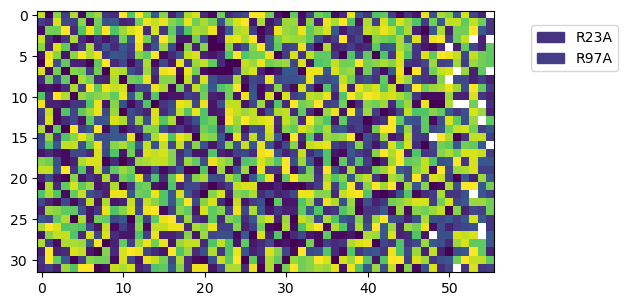

In [ ]:
filename = "my_print" # name with no file extension (e.g. 'ACYP2_muts' NOT 'ACYP2_muts.csv')

if user_binning == 'yes':
    final_array, member_count = make_cat_array(filename)
elif user_binning == 'no':
    final_array, member_count = make_array(filename)

## Write to `.fld` file

In [ ]:
for i in range(0, (total_columns)):
    for j in range(0, (total_rows)):
        current_fld_loc = str(i) + '/' + str(j)
        current_array_val = final_array[i,j]
        
        if math.isnan(current_array_val) == True:
            #print('hi')
            print(current_fld_loc + '\t' + '\t')
        else:
            array_loc_print = list(alph_dict.keys())[int(current_array_val/24)] + str(int(current_array_val % 24))
            #print(current_df)
            print(current_fld_loc + '\t' + '1' + array_loc_print + ',' + '\t' + '1,')


0/0	1B7,	1,
0/1	1A1,	1,
0/2	1B4,	1,
0/3	1A7,	1,
0/4	1B6,	1,
0/5	1A2,	1,
0/6	1B3,	1,
0/7	1B5,	1,
0/8	1A6,	1,
0/9	1A5,	1,
0/10	1B10,	1,
0/11	1B1,	1,
0/12	1B10,	1,
0/13	1B3,	1,
0/14	1A10,	1,
0/15	1B4,	1,
0/16	1A4,	1,
0/17	1A9,	1,
0/18	1B6,	1,
0/19	1B8,	1,
0/20	1A5,	1,
0/21	1A2,	1,
0/22	1B3,	1,
0/23	1A5,	1,
0/24	1A7,	1,
0/25	1A8,	1,
0/26	1B10,	1,
0/27	1B10,	1,
0/28	1B3,	1,
0/29	1A3,	1,
0/30	1A1,	1,
0/31	1B2,	1,
0/32	1A2,	1,
0/33	1A7,	1,
0/34	1B3,	1,
0/35	1B1,	1,
0/36	1A2,	1,
0/37	1A5,	1,
0/38	1B9,	1,
0/39	1A10,	1,
0/40	1A6,	1,
0/41	1B1,	1,
0/42	1B2,	1,
0/43	1A7,	1,
0/44	1A2,	1,
0/45	1A6,	1,
0/46	1A3,	1,
0/47	1B9,	1,
0/48	1A9,	1,
0/49	1B6,	1,
0/50	1B4,	1,
0/51	1A10,	1,
0/52	1B8,	1,
0/53	1A8,	1,
0/54	1A4,	1,
0/55		
1/0	1A7,	1,
1/1	1A5,	1,
1/2	1B8,	1,
1/3	1A8,	1,
1/4	1A7,	1,
1/5	1B4,	1,
1/6	1A2,	1,
1/7	1B3,	1,
1/8	1A9,	1,
1/9	1A10,	1,
1/10	1A4,	1,
1/11	1A5,	1,
1/12	1B3,	1,
1/13	1B9,	1,
1/14	1B7,	1,
1/15	1B9,	1,
1/16	1B4,	1,
1/17	1B2,	1,
1/18	1B9,	1,
1/19	1B3,	1,
1/20	1B6,	1,
1/21	1B3,	1,
1/22